# Data analysis: Covid cases over time

Data analysis of daily new covid cases in different countries, using data from:

https://github.com/CSSEGISandData/COVID-19

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
plt.style.use("ggplot")

## Import and clean up data

### Read the CSV

In [3]:
df = pd.read_csv("time_series_covid19_confirmed_global.csv")

In [4]:
df.head(3)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,57242,57364,57492,57534,57612,57721,57793,57898,58037,58214
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,128518,128752,128959,129128,129307,129456,129594,129694,129842,129980
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,118645,118799,118975,119142,119323,119486,119642,119805,119992,120174


### Remove unused columns

In [5]:
df = df.drop(["Lat", "Long"], axis=1)

In [6]:
df.head(3)

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,57242,57364,57492,57534,57612,57721,57793,57898,58037,58214
1,NaN,Albania,0,0,0,0,0,0,0,0,...,128518,128752,128959,129128,129307,129456,129594,129694,129842,129980
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,118645,118799,118975,119142,119323,119486,119642,119805,119992,120174


### Make the date a column

In [7]:
df = df.melt(id_vars=["Province/State", "Country/Region"], var_name="Date", value_name="Cases")

In [8]:
df.head(3)

,Province/State,Country/Region,Date,Cases
0,NaN,Afghanistan,1/22/20,0
1,NaN,Albania,1/22/20,0
2,NaN,Algeria,1/22/20,0


### Make values in date column proper dates

In [9]:
df["Date"] = pd.to_datetime(df["Date"])

In [10]:
df.dtypes

Province/State            object
Country/Region            object
Date              datetime64[ns]
Cases                      int64
dtype: object

In [11]:
df.head(3)

,Province/State,Country/Region,Date,Cases
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Albania,2020-01-22,0
2,NaN,Algeria,2020-01-22,0


### Sum provinces, aggregate to country level

In [12]:
df[(df["Country/Region"] == "United Kingdom") & (df["Date"] == df["Date"].max())]

,Province/State,Country/Region,Date,Cases
124923,Anguilla,United Kingdom,2021-04-21,29
124924,Bermuda,United Kingdom,2021-04-21,2226
124925,British Virgin Islands,United Kingdom,2021-04-21,194
124926,Cayman Islands,United Kingdom,2021-04-21,531
124927,Channel Islands,United Kingdom,2021-04-21,4055
124928,Falkland Islands (Malvinas),United Kingdom,2021-04-21,62
124929,Gibraltar,United Kingdom,2021-04-21,4291
124930,Isle of Man,United Kingdom,2021-04-21,1582
124931,Montserrat,United Kingdom,2021-04-21,20
124932,"Saint Helena, Ascension and Tristan da Cunha",United Kingdom,2021-04-21,4


In [13]:
df = df.groupby(["Country/Region", "Date"]).sum()

Dataframe is now indexed by country and date and selection can be done via `loc[]`:

In [14]:
df.loc["United Kingdom"].iloc[-1]

Cases    4411068
Name: 2021-04-21 00:00:00, dtype: int64

### Convert cumulative total to daily new cases

In [15]:
df.loc["United Kingdom"].iloc[-5:]

,Cases
Date,
2021-04-17,4401176
2021-04-18,4403060
2021-04-19,4406114
2021-04-20,4408644
2021-04-21,4411068


In [16]:
df = df.groupby(level=0).diff()

In [17]:
df.loc["United Kingdom"].iloc[-5:]

,Cases
Date,
2021-04-17,2273.0
2021-04-18,1884.0
2021-04-19,3054.0
2021-04-20,2530.0
2021-04-21,2424.0


### Keep only data starting from 2020-06

In [18]:
df.head(3)

Cases
Country/Region Date             
Afghanistan    2020-01-22    NaN
               2020-01-23    0.0
               2020-01-24    0.0

In [19]:
df = df.loc[(slice(None), slice(pd.to_datetime("2020-06-01"), None)), :]

In [20]:
df.head(3)

Cases
Country/Region Date             
Afghanistan    2020-06-01  545.0
               2020-06-02  759.0
               2020-06-03  758.0

## Analyze

In [21]:
date_from = pd.to_datetime("2021-01-01")
date_to   = pd.to_datetime("2021-04-22")

countries = sorted([
    "Poland",
    "Czechia",
    "Germany",
    "Austria"
])

In [22]:
def plot(df):
    fig, ax = plt.subplots(figsize=(16,5))
    df.unstack(level="Country/Region").plot(ax=ax, legend=False)
    fig.legend(loc="center right")

### Plot cases day by day

In [23]:
cases_day_by_day_df = df.loc[(countries, slice(date_from, date_to)), "Cases"]
cases_day_by_day_df.groupby(level="Country/Region").head()

Country/Region  Date      
Austria         2021-01-01     2096.0
                2021-01-02     1391.0
                2021-01-03     1466.0
                2021-01-04     1642.0
                2021-01-05     2311.0
Czechia         2021-01-01    13361.0
                2021-01-02     3447.0
                2021-01-03     5012.0
                2021-01-04     6233.0
                2021-01-05    12921.0
Germany         2021-01-01     2117.0
                2021-01-02    10903.0
                2021-01-03    10356.0
                2021-01-04    12320.0
                2021-01-05    18349.0
Poland          2021-01-01    10896.0
                2021-01-02     7006.0
                2021-01-03     5782.0
                2021-01-04     4385.0
                2021-01-05     7596.0
Name: Cases, dtype: float64

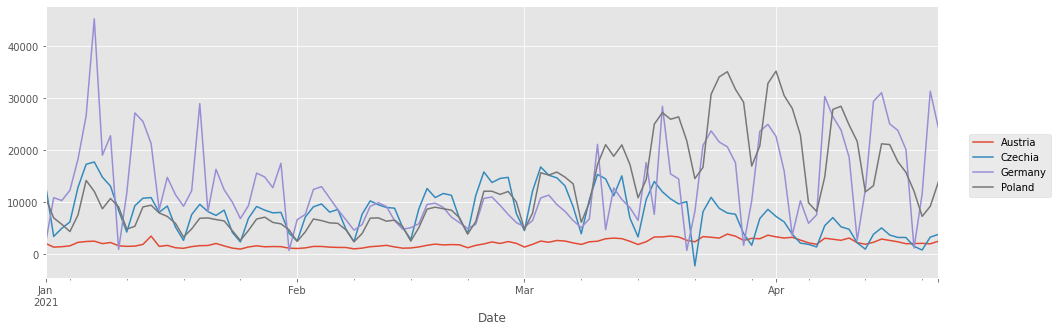

In [24]:
plot(cases_day_by_day_df)

### Plot cases week-by-week

In [25]:
def week_start(dt):
    return dt - timedelta(days=dt.weekday())

In [26]:
cases_week_by_week_df = (
    df.loc[(countries, slice(week_start(date_from), date_to)), "Cases"]
    .groupby(level="Country/Region")
    .resample("1W", level="Date")
    .sum()
)
cases_week_by_week_df.groupby(level="Country/Region").head()

Country/Region  Date      
Austria         2021-01-03     13876.0
                2021-01-10     14954.0
                2021-01-17     13056.0
                2021-01-24     10936.0
                2021-01-31      9684.0
Czechia         2021-01-03     69882.0
                2021-01-10     90684.0
                2021-01-17     57994.0
                2021-01-24     48458.0
                2021-01-31     47157.0
Germany         2021-01-03    125257.0
                2021-01-10    145514.0
                2021-01-17    120719.0
                2021-01-24     97640.0
                2021-01-31     77890.0
Poland          2021-01-03     60763.0
                2021-01-10     66960.0
                2021-01-17     50060.0
                2021-01-24     39863.0
                2021-01-31     37940.0
Name: Cases, dtype: float64

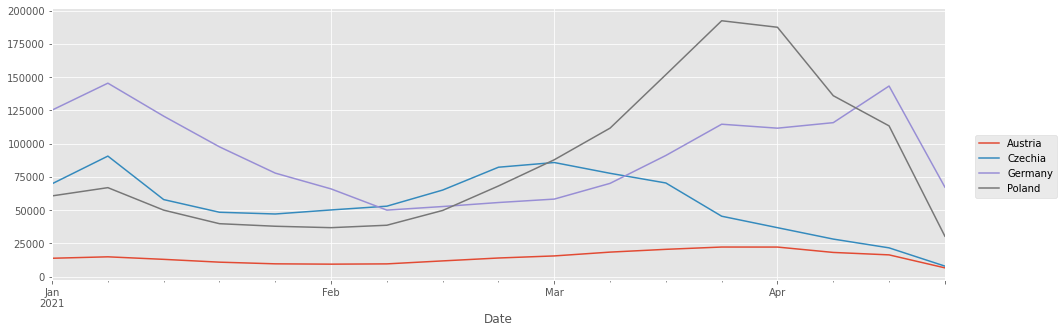

In [27]:
plot(cases_week_by_week_df)

### Plot moving average of cases

In [28]:
cases_moving_average_df = (
    df.loc[(countries, slice(date_from - timedelta(days=7), date_to)), "Cases"]
    .groupby(level="Country/Region")
    .apply(lambda df: df.rolling(7).sum())
    .loc[(countries, slice(date_from, date_to))]
)
cases_moving_average_df.groupby(level="Country/Region").head(10)

Country/Region  Date      
Austria         2021-01-01     13856.0
                2021-01-02     13818.0
                2021-01-03     13876.0
                2021-01-04     13926.0
                2021-01-05     14369.0
                2021-01-06     14288.0
                2021-01-07     13915.0
                2021-01-08     13882.0
                2021-01-09     14769.0
                2021-01-10     14954.0
Czechia         2021-01-01     67159.0
                2021-01-02     67900.0
                2021-01-03     69882.0
                2021-01-04     72374.0
                2021-01-05     74433.0
                2021-01-06     75345.0
                2021-01-07     76079.0
                2021-01-08     77579.0
                2021-01-09     87247.0
                2021-01-10     90684.0
Germany         2021-01-01    129901.0
                2021-01-02    127300.0
                2021-01-03    125257.0
                2021-01-04    123573.0
                2021-01-05    122456.

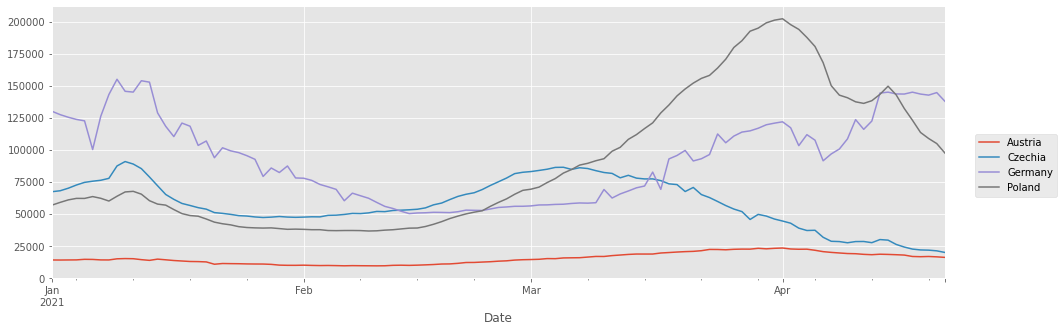

In [29]:
plot(cases_moving_average_df)